![](shopping.jpeg)

# Introduction

In the bustling world of retail, especially in grocery stores, understanding consumer preferences and shopping habits is pivotal for business optimization.

For a local grocery chain seeking to enhance customer satisfaction and drive sales I will analyze transactional data from two of its 24-hour stores, each with unique data storage practices due to the store owners' diverse backgrounds, the chain aims to uncover hidden patterns in consumer behavior.

The goal here is multifaceted: 

1. optimizing store layouts
2. tailoring marketing strategies
3. efficiently managing inventory to align with customer preferences. 

For instance, if analysis reveals that customers frequently purchase certain products together or show a preference for shopping at specific hours, the store can adjust its marketing efforts and stock levels accordingly. 

Additionally, understanding seasonal trends and weekly fluctuations in sales helps in planning promotions and staffing. Acting as the retail data scientist for this chain, I'll leverage detailed retail data to drive strategic decisions, ultimately enhancing customer experience and boosting the store's performance. 

The datasets `grocery_data1.csv` and `grocery_data2.csv` contain detailed records of grocery transactions from these two stores with the same column names:

| Variable         | Description                                           |
|------------------|-------------------------------------------------------|
| `CustomerID`     | Unique identifier for each customer                   |
| `DateRaw`        | Raw date of the transaction                           |
| `Time`           | Time of the transaction                               |
| `TransactionID`  | Unique identifier for each transaction                |
| `ProductName`    | Name of the product purchased                         |
| `PriceUSD`       | Price of the product in US dollars                    |
| `Quantity`       | Number of the product purchased                     |
| `PaymentMethod`  | Payment type used for the transaction               |
| `Category`       | Category of the product                               |



I started by installing and importing the required packages

In [103]:
if (!requireNamespace("lubridate", quietly = TRUE)) install.packages("lubridate")

In [104]:
# Import required packages
library(dplyr)
library(lubridate)
library(readr)
library(ggplot2)

Next, I loaded in the sythetic grocery data from store 1 and store 2

In [105]:
# Load and parse the time of the grocery datasets
grocery_data1 <- read_csv('grocery_data1.csv') %>% 
  mutate(Date = mdy(DateRaw))

grocery_data2 <- read_csv('grocery_data2.csv') %>% 
  mutate(Date = dmy(DateRaw))

# Merge data frames together
grocery_data <- grocery_data1 %>% 
  bind_rows(grocery_data2)

Rows: 2619 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): DateRaw, ProductName, PaymentMethod, Category
dbl  (4): CustomerID, TransactionID, PriceUSD, Quantity
time (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2581 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): DateRaw, ProductName, PaymentMethod, Category
dbl  (4): CustomerID, TransactionID, PriceUSD, Quantity
time (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Calculating Total Amount Spent by Customers

In this step, we calculate the total amount spent on each transaction. This is achieved by multiplying the price of each item (`PriceUSD`) by the quantity purchased (`Quantity`). The resulting value, stored as `TotalSaleUSD`, represents the total expenditure for each purchase.

This calculation provides insights into revenue contributions across different transactions.


In [106]:
# Obtain the total amount spent: TotalSaleUSD = PriceUSD * Quantity
grocery_data <- grocery_data %>%
  mutate(TotalSaleUSD = PriceUSD * Quantity)

In [107]:
head(grocery_data,2)

CustomerID,DateRaw,Time,TransactionID,ProductName,PriceUSD,Quantity,PaymentMethod,Category,Date,TotalSaleUSD
<dbl>,<chr>,<time>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>,<dbl>
41,"June 28, 2023",20:00:00,2,Apples,5.64,5,Cash,Produce,2023-06-28,28.20
170,"August 18, 2023",06:00:00,3,Apples,17.92,1,Mobile Payment,Produce,2023-08-18,17.92



To predict customer behaviour, I will examine the time intervals between purchases of the same product. By analyzing the number of days between consecutive purchases, patterns or trends that can provide insights into customer buying habits and preferences can be determined.

In [108]:
# Calculate the time since each customer purchased each ProductName
grocery_data_grouped <- grocery_data %>%
  arrange(CustomerID, Date) %>% 
  group_by(CustomerID, ProductName) %>%
  mutate(
    DaysSinceLastPurchase = as.numeric(c(0, diff(Date))),  # Calculate the number of days since the last purchase of that commodity
    Week = week(Date),  # Week number in that year
    Year = year(Date),  # Year the purchase was made
    Hour = hour(Time)  # Hour the purchase was made
  ) %>%
  ungroup()

In [109]:
head(grocery_data_grouped,2)

CustomerID,DateRaw,Time,TransactionID,ProductName,PriceUSD,Quantity,PaymentMethod,Category,Date,TotalSaleUSD,DaysSinceLastPurchase,Week,Year,Hour
<dbl>,<chr>,<time>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,01 June 2023,01:00:00,111,Bread,6.14,3,Credit Card,Bakery,2023-06-01,18.42,0,22,2023,1
1,01 June 2023,10:00:00,1012,Carrots,0.97,2,Credit Card,Produce,2023-06-01,1.94,0,22,2023,10


### Analyzing Weekly Sales Trends

To gain insights into sales trends, I computed the weekly figures for `TotalSaleUSD`. Organizing the data into weekly segments could potentially identify patterns such as peak sales periods and potential areas for improvement

In [110]:
# Calculate weekly figures for TotalSaleUSD
weekly_sales <- grocery_data_grouped %>%
  group_by(Year, Week) %>%
  summarize(WeeklyTotalSaleUSD = sum(TotalSaleUSD)) %>% 
  arrange(Week, Year) %>% 
  ungroup()

`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


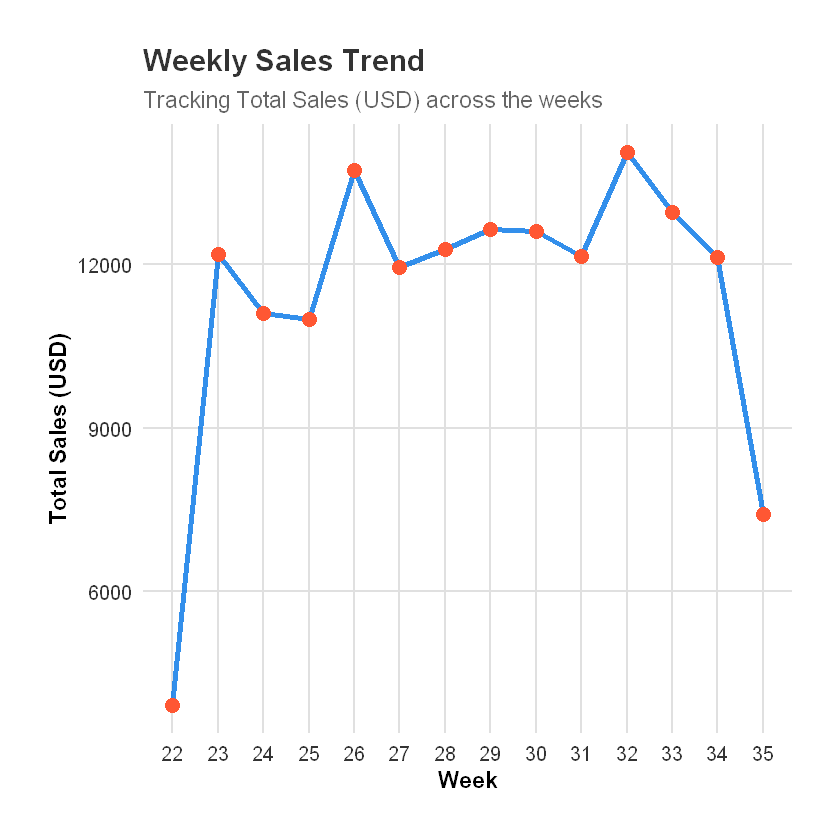

In [111]:
# Weekly Sales Trend 
ggplot(weekly_sales, aes(x = Week, y = WeeklyTotalSaleUSD)) +
  geom_line(color = "#0073e6", size = 1.5, alpha = 0.8) +  # Blue line with adjusted thickness and transparency
  geom_point(color = "#ff5733", size = 4, shape = 16) +  # Adding red points for each week
  labs(title = "Weekly Sales Trend", 
       subtitle = "Tracking Total Sales (USD) across the weeks", 
       x = "Week", 
       y = "Total Sales (USD)") +
  theme_minimal(base_size = 15) +  # Minimal theme with larger base font size
  theme(
    plot.title = element_text(face = "bold", size = 18, color = "#333333"),
    plot.subtitle = element_text(size = 14, color = "#666666"),
    axis.title = element_text(face = "bold", size = 14),
    axis.text = element_text(size = 12, color = "#333333"),
    panel.grid.major = element_line(color = "#e0e0e0"),  # Light grey grid lines
    panel.grid.minor = element_blank(),
    plot.margin = margin(1, 1, 1, 1, "cm")  # Add some margin for better visual spacing
  ) +
  scale_x_continuous(breaks = seq(1, max(weekly_sales$Week), by = 1))  # Ensure week labels are shown clearly


The code below aims to identify the week of the year with the most consistent sales performance compared to the company's average weekly sales. By calculating and analyzing the absolute deviation of each week's sales from the mean weekly sales value, the code pinpoints the week where sales were closest to the average.

In [127]:
# What week of the year during the time period had the smallest absolute deviation in sales value compared to the mean WeeklyTotalSaleUSD?
mean(weekly_sales$WeeklyTotalSaleUSD)
weekly_sales <- weekly_sales %>% 
  mutate(Diff = abs(WeeklyTotalSaleUSD - mean(WeeklyTotalSaleUSD))) %>% 
  arrange(Diff)
smallest_sales_deviation <- 24

weekly_sales

[1] 11442.88

Year,Week,WeeklyTotalSaleUSD,Diff
<dbl>,<dbl>,<dbl>,<dbl>
2023,24,11111.63,331.2514
2023,25,11005.97,436.9114
2023,27,11954.92,512.0386
2023,34,12144.57,701.6886
2023,31,12154.19,711.3086
2023,23,12189.07,746.1886
2023,28,12286.75,843.8686
2023,30,12617.20,1174.3186
2023,29,12652.53,1209.6486


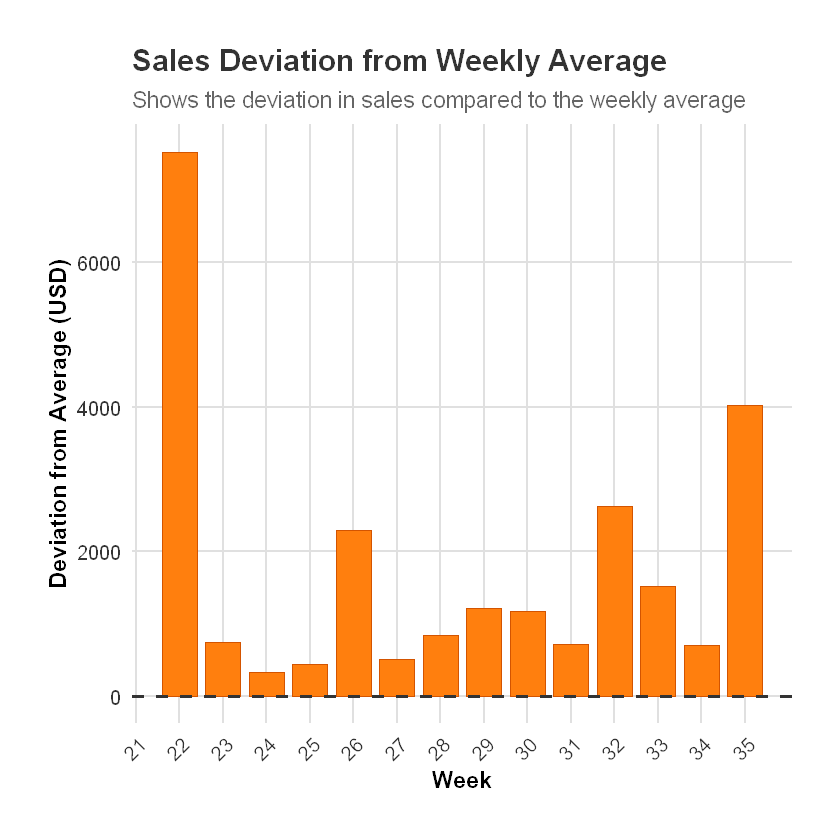

In [128]:
# Sales Deviation from Weekly Average
ggplot(weekly_sales, aes(x = Week, y = Diff)) +
  geom_bar(stat = "identity", fill = "#FF7F0E", color = "#D35400", width = 0.8) +  # Orange bars with darker borders
  labs(title = "Sales Deviation from Weekly Average", 
       subtitle = "Shows the deviation in sales compared to the weekly average", 
       x = "Week", 
       y = "Deviation from Average (USD)") +
  theme_minimal(base_size = 15) +  # Minimal theme with larger font sizes
  theme(
    plot.title = element_text(face = "bold", size = 18, color = "#333333"),
    plot.subtitle = element_text(size = 14, color = "#666666"),
    axis.title = element_text(face = "bold", size = 14),
    axis.text = element_text(size = 12, color = "#333333"),
    panel.grid.major = element_line(color = "#e0e0e0"),  # Light grey grid lines
    panel.grid.minor = element_blank(),
    plot.margin = margin(1, 1, 1, 1, "cm"),  # Add some margin for better spacing
    axis.text.x = element_text(angle = 45, hjust = 1)  # Tilt x-axis labels for better readability
  ) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#333333", size = 1) +  # Add a dashed line at y=0 for reference
  scale_x_continuous(breaks = seq(1, max(weekly_sales$Week), by = 1))  # Ensure week labels are clearly shown


## Weekly Sales Consistency Analysis

From the analysis, we observe the weekly sales (`WeeklyTotalSaleUSD`) and their corresponding absolute deviations from the mean weekly sales (`Diff`). Below are the key insights:

### 1. Week with Smallest Deviation (Most Consistent Sales)
- **Week 24 (2023)** has the smallest deviation from the mean, with a `Diff` of **331.25**.
- This indicates that sales during this week were closest to the average weekly sales, suggesting a period of stable or predictable sales performance.

### 2. Weeks with Significant Deviations
- **Week 22 (2023):** This week shows the largest deviation, with a `Diff` of **7535.88**, indicating much lower sales than the average. Potential reasons could include seasonal downturns, reduced demand, or other operational challenges.
- **Week 35 (2023):** This week also exhibits a large deviation, with a `Diff` of **4023.07**, reflecting another significant drop in sales. Further investigation is needed to determine whether external factors or market conditions caused this decline.

### 3. Weeks with Higher-than-Average Sales
- Several weeks, such as **Weeks 32, 33, 29, 30**, and **26**, show high sales values, with deviations exceeding **2000 USD**.
- These weeks may represent periods of strong demand or successful marketing efforts where sales exceeded the usual levels.

### 4. Sales Trends and Operational Implications
- **Stable Weeks:** Week 24, with the smallest deviation, might reflect a time of normal operations. This information could guide inventory planning and staffing for similar weeks in the future.
- **Periods of High Sales:** Weeks with higher-than-usual sales could be analyzed for trends, such as successful promotional campaigns or seasonal events that boosted demand.
- **Low Sales Weeks:** Weeks like Week 22 and Week 35, with large deviations, may indicate issues or external factors leading to poor performance. These insights could highlight opportunities for operational improvements or better alignment with market conditions.

### Summary
The analysis identifies **Week 24** as the most consistent week in terms of sales, while **Week 22** shows the largest deviation due to significantly lower sales. Understanding these patterns can help the company better forecast future performance, adjust for seasonal variations, and optimize strategies for improving sales consistency.


### Calculating Hourly Sales Figures

The code below calculates the total sales (`TotalSaleUSD`) for each hour of the day. Here's a breakdown of the steps involved:

1. **Group Data by Hour:** The dataset is grouped based on the `Hour` column to aggregate sales figures for each hour.
2. **Summarize Sales:** The total sales for each hour are computed by summing up the `TotalSaleUSD` values within each group, resulting in `HourlyTotalSaleUSD`.
3. **Ungroup Data:** The grouping is removed to allow for further processing.
4. **Sort Results:** The data is sorted in descending order of `HourlyTotalSaleUSD` to identify the hours with the highest sales.

This analysis provides insights into hourly sales patterns, helping identify peak sales hours, which can be crucial for optimizing operations, staffing, and marketing strategies.


In [114]:
# Calculate hourly figures for TotalSaleUSD
hourly_sales <- grocery_data_grouped %>%
  group_by(Hour) %>%
  summarize(HourlyTotalSaleUSD = sum(TotalSaleUSD)) %>% 
  ungroup() %>%
  arrange(desc(HourlyTotalSaleUSD))

In [115]:
hourly_sales

Hour,HourlyTotalSaleUSD
<int>,<dbl>
22,8476.95
8,8164.50
13,7523.40
6,7383.21
10,7286.96
5,7242.81
21,7235.86
0,7125.01
16,6897.30


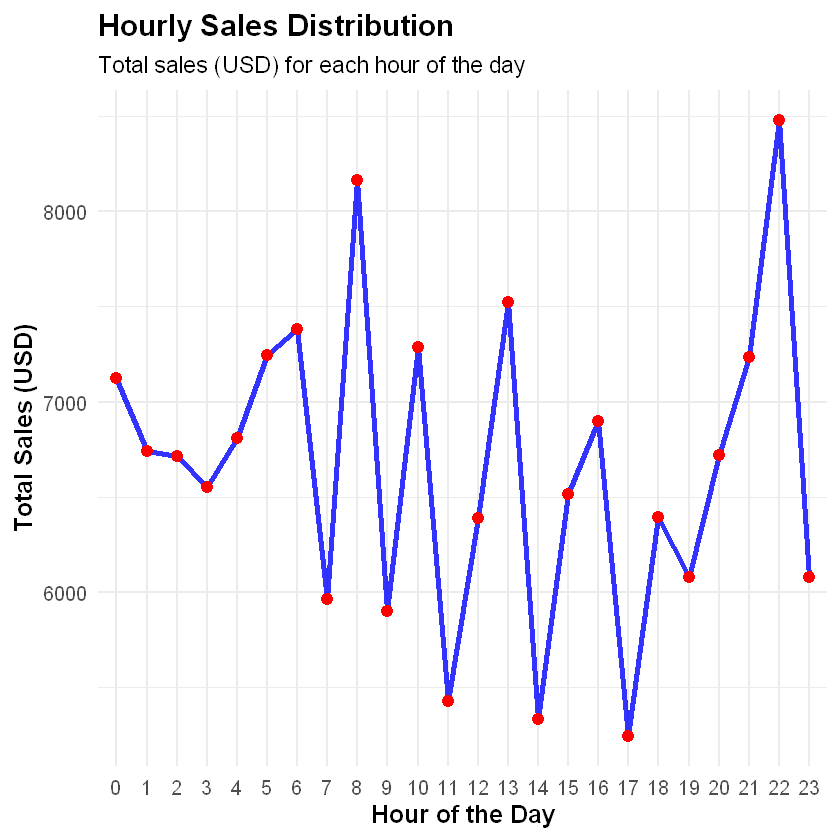

In [116]:
# Hourly Sales Distribution 
hourly_sales <- grocery_data_grouped %>%
  group_by(Hour) %>%
  summarize(HourlyTotalSaleUSD = sum(TotalSaleUSD)) %>%
  ungroup() %>%
  arrange(Hour)

# Create the line plot 
ggplot(hourly_sales, aes(x = factor(Hour), y = HourlyTotalSaleUSD, group = 1)) +  # group = 1 ensures a single line
  geom_line(color = "blue", linewidth = 1.5, alpha = 0.8) +  # Replacing `size` with `linewidth`
  geom_point(color = "red", size = 3) +  # Red points for each hour
  labs(title = "Hourly Sales Distribution", 
       subtitle = "Total sales (USD) for each hour of the day", 
       x = "Hour of the Day", 
       y = "Total Sales (USD)") +
  theme_minimal(base_size = 15) +  # Clean minimal theme
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 14),
    axis.title = element_text(face = "bold"),
    axis.text = element_text(size = 12)
  ) + 
  scale_x_discrete(breaks = seq(0, 23, 1))  # Ensure all hours are labeled


## Hourly Sales Analysis Report

The following analysis summarizes the hourly sales (`HourlyTotalSaleUSD`) for a given period, using data aggregated in a 24-hour format. The goal is to identify peak sales periods and provide insights for optimizing operational efficiency and marketing strategies.

### Key Observations:

1. **Peak Sales Hours:**
   - The highest total sales were recorded during **22:00 (10 PM)** with a value of **8,476.95 USD**, indicating that late evening is a significant period for sales activity.
   - Other high-performing hours include:
     - **08:00 (8 AM):** **8,164.50 USD**
     - **13:00 (1 PM):** **7,523.40 USD**
     - **06:00 (6 AM):** **7,383.21 USD**

   These hours reflect strong sales trends, possibly due to customer habits or targeted promotions.

2. **Moderate Sales Hours:**
   - Sales during hours such as **10:00 (10 AM)** with **7,286.96 USD** and **05:00 (5 AM)** with **7,242.81 USD** represent consistent yet moderate performance.
   - Late-night hours like **00:00 (midnight)** also show steady sales of **7,125.01 USD**, suggesting activity even during off-peak times.

3. **Lower Sales Hours:**
   - The hours with the lowest total sales include:
     - **17:00 (5 PM):** **5,246.81 USD**
     - **14:00 (2 PM):** **5,334.77 USD**
     - **11:00 (11 AM):** **5,426.39 USD**

   These periods may reflect reduced customer engagement, highlighting opportunities to investigate potential causes such as shifts in customer behavior or lack of targeted promotions.

### Insights:

- **High-Efficiency Hours:** 
  - Late evenings (e.g., 22:00) and early mornings (e.g., 08:00) are critical hours for sales. Companies could leverage these periods by increasing staffing, extending store hours, or running time-specific promotions.

- **Low Activity Periods:** 
  - Hours like 17:00 and 14:00, with relatively lower sales, may benefit from targeted interventions such as flash sales or loyalty program incentives to boost activity.

- **Consistent Activity:** 
  - The presence of steady sales across most hours indicates a relatively balanced distribution, suggesting the company benefits from a consistent flow of customers throughout the day.

### Conclusion:
This analysis provides actionable insights into hourly sales patterns, identifying both peak and low activity periods. Businesses can use this information to optimize operations, enhance customer engagement, and develop time-specific marketing strategies to maximize revenue.


### Analyzing Milk Purchases for CustomerID 1

The code below analyzes the **Milk** purchases made by **CustomerID 1**. Here's a breakdown of the steps involved:

1. **Filter Data by CustomerID and ProductName:** The dataset is filtered to include only transactions made by **CustomerID 1** and for the product "Milk".
2. **Extract Relevant Information:** For each relevant transaction, key details such as the transaction date, price, quantity, and total sales are captured, along with the time of purchase.
3. **Analyze Purchase Patterns:** By filtering the data to only include purchases of "Milk", we gain insights into the frequency, amounts spent, and payment methods for this specific product.
4. **Review Time-based Trends:** The data includes information on the day and hour of each purchase, providing insights into when **CustomerID 1** tends to make purchases.

This analysis provides valuable insights into the purchasing behavior of **CustomerID 1** for the product "Milk", such as how frequently they buy it, the average spend per purchase, and any time-based trends that could inform inventory management, marketing, and customer engagement strategies.


In [117]:
# Examine Milk purchases for CustomerID 1
grocery_data_grouped %>% 
  filter(CustomerID == 1) %>% 
  filter(ProductName == "Milk")


CustomerID,DateRaw,Time,TransactionID,ProductName,PriceUSD,Quantity,PaymentMethod,Category,Date,TotalSaleUSD,DaysSinceLastPurchase,Week,Year,Hour
<dbl>,<chr>,<time>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,07 June 2023,05:00:00,1346,Milk,9.81,1,Cash,Dairy,2023-06-07,9.81,0,23,2023,5
1,17 June 2023,18:00:00,3677,Milk,16.28,2,Debit Card,Dairy,2023-06-17,32.56,10,24,2023,18
1,30 June 2023,17:00:00,379,Milk,19.02,4,Credit Card,Dairy,2023-06-30,76.08,13,26,2023,17
1,01 July 2023,12:00:00,4828,Milk,14.40,3,Mobile Payment,Dairy,2023-07-01,43.20,1,26,2023,12
1,05 July 2023,03:00:00,85,Milk,13.94,4,Credit Card,Dairy,2023-07-05,55.76,4,27,2023,3


### Key Observations:
- **Purchase Dates**: The purchases of Milk by CustomerID 1 span from **7 June 2023** to **5 July 2023**, indicating that the customer made several Milk purchases over the course of about a month.
- **Quantities Purchased**: The customer bought varying quantities of Milk in each transaction, ranging from 1 unit to 4 units.
- **Total Sale Amount**: The total sale amount fluctuates according to the quantity purchased:
  - The first purchase on **7 June 2023** was for **1 unit** of Milk, totaling **9.81 USD**.
  - The second purchase on **17 June 2023** was for **2 units**, totaling **32.56 USD**.
  - The third purchase on **30 June 2023** was for **4 units**, totaling **76.08 USD**.
- **Payment Methods**: The customer used various payment methods, including **Cash**, **Debit Card**, **Credit Card**, and **Mobile Payment**.
- **Time of Day**: The purchases occurred at different hours of the day, ranging from early morning (**5 AM**) to late evening (**6 PM** or later).
- **Days Since Last Purchase**: The `DaysSinceLastPurchase` column shows varying intervals between purchases, such as **10 days** between the first and second purchase, and **3 days** between the fourth and fifth purchase.

### Conclusion:
The analysis of CustomerID 1's Milk purchases reveals several insights into their buying behavior:
- **Frequency**: Customer 1 made several Milk purchases across a month, with varying time gaps between purchases.
- **Purchase Patterns**: The customer tends to buy Milk in different quantities, with some transactions involving multiple units.
- **Payment Preferences**: There is no single preferred payment method, as the customer used a mix of Cash, Debit Card, Credit Card, and Mobile Payment.
- **Time of Day**: The purchases are spread throughout the day, with no clear preference for a particular time.
- **Potential Applications**: This information can be useful for understanding purchasing behavior, planning inventory, and creating targeted marketing strategies for this customer or similar ones.


### Analyzing the Top 10 and Bottom 10 Products by Revenue

In this section, we analyze the top and bottom 10 products that have contributed the most and the least to total revenue. This analysis can reveal valuable insights into which products are overperforming underperforming and might require further investigation or strategic adjustments.


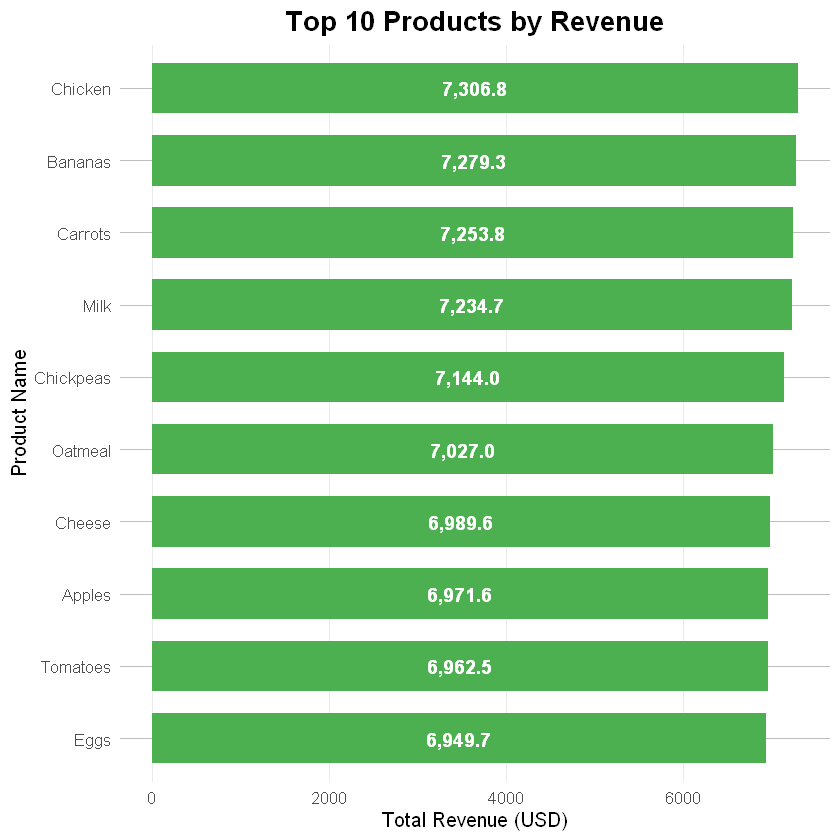

In [118]:
# Group by ProductName and summarize total revenue (TotalSaleUSD)
top_products <- grocery_data_grouped %>%
  group_by(ProductName) %>%
  summarize(TotalRevenue = sum(TotalSaleUSD)) %>%  # Summing up TotalSaleUSD for each product
  arrange(desc(TotalRevenue)) %>%  # Sorting the data by TotalRevenue in descending order
  head(10)  # Getting the top 10 products with the most revenue

# Create a bar chart with numbers on the bars
ggplot(top_products, aes(x = reorder(ProductName, TotalRevenue), y = TotalRevenue)) +
  geom_bar(stat = "identity", fill = "#4CAF50", width = 0.7) +  # green bars
  coord_flip() +  # Flip coordinates for horizontal bars
  labs(title = "Top 10 Products by Revenue", x = "Product Name", y = "Total Revenue (USD)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.major.y = element_line(color = "gray", size = 0.2),
    panel.grid.minor = element_blank()
  ) +
  geom_text(aes(label = scales::comma(TotalRevenue)), # Adding numbers to the bars
            position = position_stack(vjust = 0.5), # Centers the text inside the bars
            size = 4, color = "white", fontface = "bold") # Styling the text


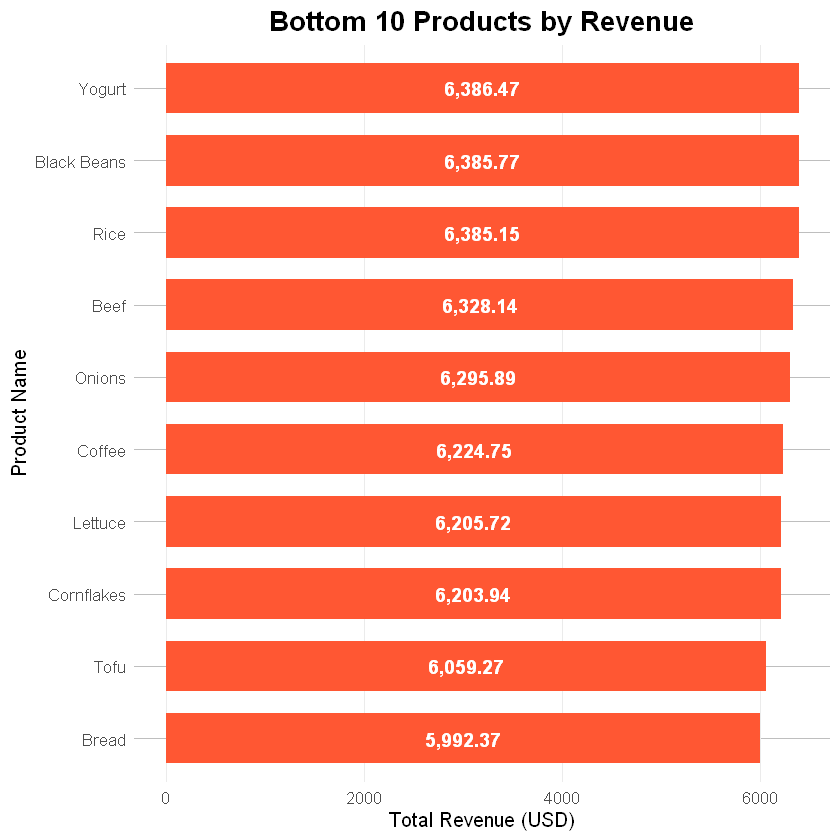

In [119]:
library(ggplot2)
library(dplyr)

# Group by ProductName and summarize total revenue (TotalSaleUSD)
bottom_products <- grocery_data_grouped %>%
  group_by(ProductName) %>%
  summarize(TotalRevenue = sum(TotalSaleUSD)) %>%  # Summing up TotalSaleUSD for each product
  arrange(TotalRevenue) %>%  # Sorting the data by TotalRevenue in ascending order
  head(10)  # Getting the bottom 10 products with the least revenue

# Create a bar chart with numbers on the bars for the bottom 10 products
ggplot(bottom_products, aes(x = reorder(ProductName, TotalRevenue), y = TotalRevenue)) +
  geom_bar(stat = "identity", fill = "#FF5733", width = 0.7) +  # orange bars for the bottom products
  coord_flip() +  # Flip coordinates for horizontal bars
  labs(title = "Bottom 10 Products by Revenue", x = "Product Name", y = "Total Revenue (USD)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.major.y = element_line(color = "gray", size = 0.2),
    panel.grid.minor = element_blank()
  ) +
  geom_text(aes(label = scales::comma(TotalRevenue)), # Adding numbers to the bars
            position = position_stack(vjust = 0.5), # Centers the text inside the bars
            size = 4, color = "white", fontface = "bold") # Styling the text



# Summary of Sales Analysis

In this analysis, we have explored various aspects of sales data, focusing on understanding key sales patterns, identifying trends, and analyzing customer behavior. The following key insights were derived:

1. **Weekly Sales Consistency:**
   - We identified the week with the smallest deviation from the mean sales, indicating a period of stable sales.
   - Weeks with significant deviations (both high and low) were examined, highlighting potential areas of concern or opportunity for the business.
   - Several weeks with above-average sales were also analyzed, shedding light on periods of strong demand that may be driven by marketing efforts, promotions, or seasonal factors.

2. **Hourly Sales Analysis:**
   - We computed the total sales for each hour of the day, revealing peak sales hours.
   - These insights can be used to optimize staffing, promotions, and operational efforts during high-sales periods, potentially increasing overall revenue.

3. **Product-Specific Analysis:**
   - We performed a detailed analysis of purchases for specific products, such as Milk, by individual customers, providing insights into purchasing frequency, amounts spent, and preferred payment methods.
   - This analysis could inform personalized marketing strategies and inventory management.

### Conclusion

The analysis presented above provides valuable insights into sales trends, customer purchasing behavior, and operational optimization opportunities. However, it is important to note that this is not an exhaustive analysis. The data holds vast potential for deeper exploration. There is much more that can be done with the data, including further segmentation of customer behavior, predictive modeling for sales forecasting, and more detailed time-series analysis to uncover seasonal trends or the impact of specific marketing campaigns.

This analysis represents only a portion of the broader potential insights this imaginary company can extract to improve decision-making and drive business growth.
